In [1]:
!pip install mdtraj

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md
import sys
sys.path.append('/content/drive/MyDrive/AF2RAVE-Glide/kinase_Aloop/')
import os
import networkx as nx
from matplotlib import cm
import kinaseCVs as kcv
import glob
import re
import pickle
from kinaseCVs import resids_Abl1
from kinaseCVs import resids_DDR1
xbin = np.linspace(-1,0,51)
ybin = np.linspace(-0.1,1,51)

**Load SPIB coordinates**

In [4]:
round = '/content/drive/MyDrive/AF2RAVE-Glide/SPIB_std_filter/round1'
op_id = [int(x) for x in np.loadtxt(f'{round}/op_id.txt')]

op_max = np.load(f"{round}/DDR1_input/max_unb.npy")
op_min = np.load(f"{round}/DDR1_input/min_unb.npy")
lag = 8000
dt = f"{lag*2e-3} ns"
prefix=f"{round}/dt-{lag}/SPIB/Unweighted_d=2_t={lag}_b=0.0500_learn=0.000100_"
weights=np.load(prefix+"z_mean_encoder_weight0.npy")

wts = weights/(op_max-op_min)
print(op_id)
print(wts)

[1, 2, 3, 7, 8, 10, 11, 12]
[[ 0.09284084  0.04113295 -0.31039463  0.09656175 -0.02102127 -0.10813012
  -0.04166198  0.01493557]
 [ 0.11358153  0.13575025  0.03890331  0.34705924  0.11752161 -0.32470332
   0.20966233 -0.09062353]]


In [6]:
os.chdir('/content/drive/MyDrive/AF2RAVE-Glide/')

# **DDR1**

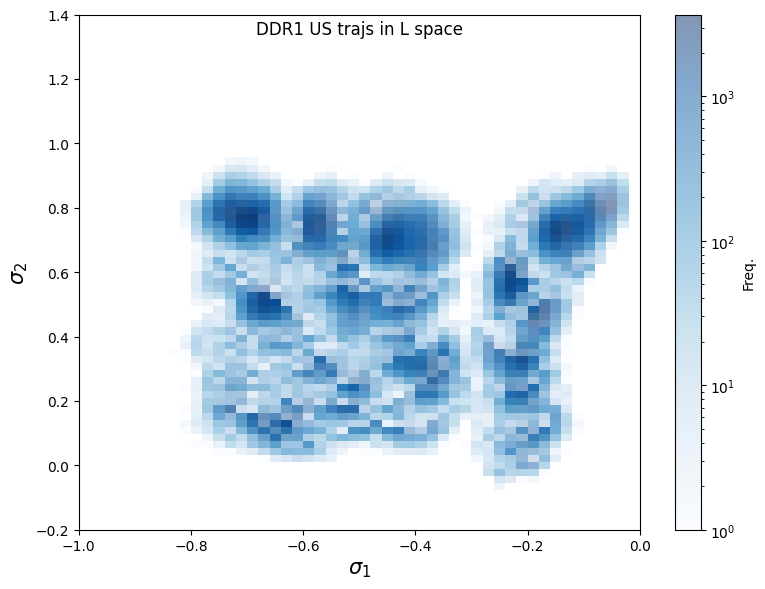

In [10]:
folder = '/content/drive/MyDrive/AF2RAVE-Glide/US_DDR1'
plt.figure(figsize=(8, 6))
for i in range(112):
    cv_array = np.loadtxt(f'{folder}/cvs/w{i}.txt')
    plt.hist2d(x=cv_array.T[1], y=cv_array.T[2],cmap="Blues", norm='log',alpha=0.5, bins = [xbin,ybin])

plt.title('DDR1 US trajs in L space',y=1.0, pad=-14)
plt.xlabel("$\sigma_1$",fontsize=15)
plt.ylabel("$\sigma_2$",fontsize=15)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
plt.colorbar(label='Freq.')
plt.tight_layout()
plt.savefig(f"figures/DDR1_lspace_us.png",dpi=300)

<ipython-input-11-50a3b3297c35>:18: RuntimeWarning: divide by zero encountered in log
  v1 = np.where(a>0, np.log(a), 0)
<ipython-input-11-50a3b3297c35>:24: RuntimeWarning: divide by zero encountered in log
  v2 = np.where(a>0, np.log(a), 0)
<ipython-input-11-50a3b3297c35>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


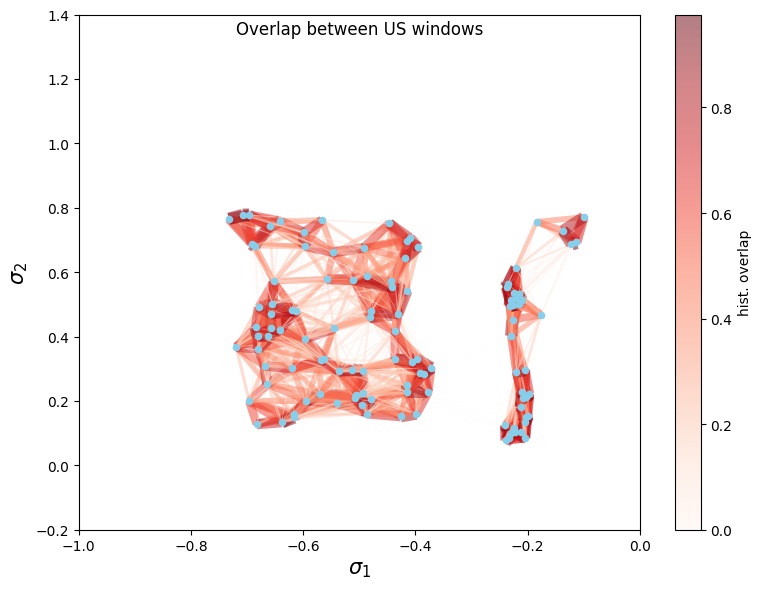

In [11]:
G = nx.Graph()
# node positions
pos = {}
for i in range(112):
    cv_array = np.loadtxt(f'{folder}/cvs/w{i}.txt')
    pos[i] = (np.mean(cv_array.T[1]), np.mean(cv_array.T[2]))
G.add_nodes_from(pos.keys())

edge = []
edge_widths = []
xbin = np.linspace(-1,0,51)
ybin = np.linspace(-0.1,1,51)

for i in range(112):
    cv_array1 = np.loadtxt(f'{folder}/cvs/w{i}.txt')
    hist1, _, _ = np.histogram2d(cv_array1.T[1], cv_array1.T[2], bins = [xbin,ybin])
    a = np.concatenate(hist1)
    v1 = np.where(a>0, np.log(a), 0)
    for j in range(i+1,112):
        edge.append((i,j))
        cv_array2 = np.loadtxt(f'{folder}/cvs/w{j}.txt')
        hist2, _, _ = np.histogram2d(cv_array2.T[1], cv_array2.T[2], bins = [xbin,ybin])
        a = np.concatenate(hist2)
        v2 = np.where(a>0, np.log(a), 0)
        edge_widths.append(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2))

for ed, width in zip(edge, edge_widths):
    G.add_edge(*ed, width=width)

# Draw the graph
fig, ax = plt.subplots(figsize=(8, 6))
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue',ax=ax)

# Draw edges with specified widths
widths = [G[edge[0]][edge[1]]['width']*10 for edge in G.edges()]
cmap = cm.get_cmap('Reds')
g_edge = nx.draw_networkx_edges(G, pos, width=widths, edge_color=edge_widths, edge_cmap=cmap, alpha=0.5,ax=ax)

# Show the plot
#plt.title("Graph with Edge Widths")
plt.title('Overlap between US windows',y=1.0, pad=-14)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel("$\sigma_1$",fontsize=15)
plt.ylabel("$\sigma_2$",fontsize=15)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
plt.colorbar(g_edge, label='hist. overlap')
plt.tight_layout()
plt.savefig(f"figures/DDR1_lspace_us_G.png",dpi=300)

In [14]:
# Output umbrella sampling windows for the Aloop-folded region

tmp_edge = []
for edge in G.edges():
    if G[edge[0]][edge[1]]['width'] > 0.1:
        tmp_edge.append(((edge[0],edge[1])))
G1 = nx.Graph()
G1.add_nodes_from(pos.keys())
for ed in tmp_edge:
    G1.add_edge(*ed)

groups = list(nx.connected_components(G1))
eps = np.loadtxt(f'{folder}/eps.txt')
print(len(groups[0]))
for i in groups[0]:
    print(i,eps[i][0], eps[i][1])
# file_path = 'wham1/meta.txt'
# with open(file_path, 'w') as file:
#     for i in groups[0]:
#         print(i,eps[i][0], eps[i][1])
#         file.write(f"/home/xgu/Tiwary/AF2RAVE/US/cvs/w{i}.txt {eps[i][0]} {eps[i][1]} 1000 1000\n")

75
0 -0.8 0.0
1 -0.73 0.0
2 -0.66 0.0
3 -0.59 0.0
4 -0.52 0.0
5 -0.45 0.0
11 -0.8 0.08
12 -0.73 0.08
13 -0.66 0.08
14 -0.59 0.08
15 -0.52 0.08
16 -0.45 0.08
17 -0.38 0.08
22 -0.8 0.16
23 -0.73 0.16
24 -0.66 0.16
25 -0.59 0.16
26 -0.52 0.16
27 -0.45 0.16
28 -0.38 0.16
33 -0.8 0.24
34 -0.73 0.24
35 -0.66 0.24
36 -0.59 0.24
37 -0.52 0.24
38 -0.45 0.24
39 -0.38 0.24
40 -0.31 0.24
44 -0.8 0.32
45 -0.73 0.32
46 -0.66 0.32
47 -0.59 0.32
48 -0.52 0.32
49 -0.45 0.32
50 -0.38 0.32
51 -0.31 0.32
55 -0.8 0.4
56 -0.73 0.4
57 -0.66 0.4
58 -0.59 0.4
59 -0.52 0.4
60 -0.45 0.4
61 -0.38 0.4
66 -0.8 0.48
67 -0.73 0.48
68 -0.66 0.48
69 -0.59 0.48
70 -0.52 0.48
71 -0.45 0.48
72 -0.38 0.48
77 -0.8 0.56
78 -0.73 0.56
79 -0.66 0.56
80 -0.59 0.56
81 -0.52 0.56
82 -0.45 0.56
83 -0.38 0.56
88 -0.8 0.64
89 -0.73 0.64
90 -0.66 0.64
91 -0.59 0.64
92 -0.52 0.64
93 -0.45 0.64
94 -0.38 0.64
95 -0.31 0.64
99 -0.8 0.72
100 -0.73 0.72
101 -0.66 0.72
102 -0.59 0.72
103 -0.52 0.72
104 -0.45 0.72
105 -0.38 0.72
106 -0.31 0.

**Assign Boltzmann Rank**

In [16]:
traj = md.load("rAF2/DDR1/DDR1_AF2.xtc", top='rAF2/DDR1/DDR1_MSA16/pred_1.pdb')
cv = kcv.kinase_cvs("DDR1",traj.top,resids_DDR1,traj)
CVs = []
for i in range(len(cv.allcvs)):
    CVs.append(cv.allcvs[i].traj)
CVs = np.transpose(CVs)
ls_array = CVs[:, op_id]
ls_array = np.dot(ls_array, wts.T)

pres = [74 ,307 ,605 ,671 ,854 ,901 ,915 ,940 ,960 ,1001 ,1007 ,1107 ,1130 ,1134 ,1137]
tls = ls_array[pres]

In [37]:
mcs_ct = 0.7
temps = ['3ZOS']
rank = pd.DataFrame()
rank['pre'] = pres
for ii, temp in enumerate(temps):
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'IFD_valid/DDR1/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        marks.append(np.min(sub[f'{temp}_l_RMSD']))
    rank[f'l_rmsd_{temp}'] = marks


a=pd.read_csv(f'{folder}/wham1/PMF.txt', header=None, delim_whitespace=True, comment='#')
a.columns = ['xx', 'yy', 'pmf','prob']
# a=b[b.pmf<9999]
minp=np.min(a.pmf)
ct=0.05
pmfs = []
for tt in range(len(tls)):
    print(pres[tt], tls[tt])
    tx=tls[tt][0]
    ty=tls[tt][1]
    b=a[(a.xx>tx-ct) & (a.xx<tx+ct) & (a.yy>ty-ct) & (a.yy<ty+ct)]
    cand = []
    cand.append(list(b.xx))
    cand.append(list(b.yy))
    cand = np.transpose(cand)
    out_id = np.argmin(np.linalg.norm(tls[tt]-cand, axis=1))
    pmfs.append(np.round(b.iloc[out_id]['pmf'], decimals=3))
rank['pmf'] = pmfs

74 [-0.54009919  0.82502429]
307 [-0.5757114   0.68653629]
605 [-0.52783815  0.68571525]
671 [-0.57349613  0.79807274]
854 [-0.54817133  0.97467329]
901 [-0.47950491  0.8221878 ]
915 [-0.55038828  0.78134381]
940 [-0.54569614  0.73217465]
960 [-0.46762673  0.91877299]
1001 [-0.49383592  0.79589496]
1007 [-0.50833605  0.73168547]
1107 [-0.58676525  0.73262632]
1130 [-0.46794345  0.62159767]
1134 [-0.45740982  0.84440175]
1137 [-0.41946377  0.7432849 ]


In [39]:
rank.sort_values(by=['pmf'])

,pre,l_rmsd_3ZOS,pmf
3,671,8.348188,0.373
0,74,0.893124,0.570
13,1134,9.545475,1.131
6,915,10.738065,1.448
5,901,7.610077,1.623
11,1107,10.330336,2.072
1,307,12.575509,2.689
9,1001,11.395496,3.816
7,940,10.603996,4.017
2,605,6.959693,4.207


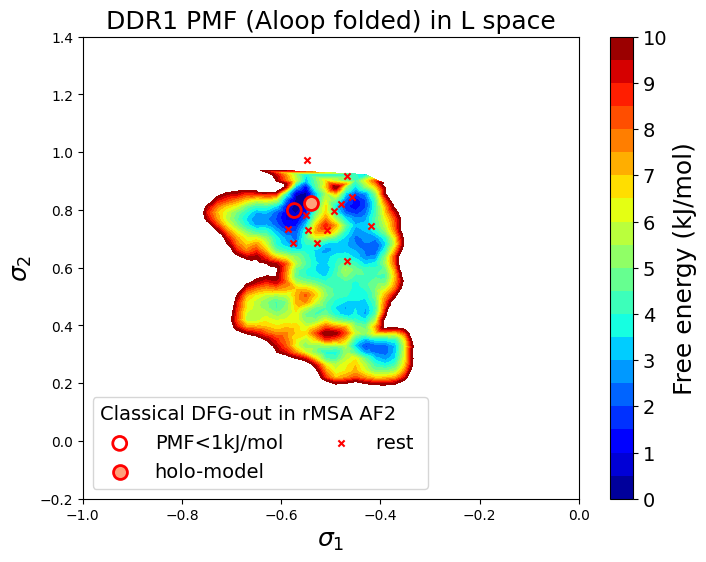

In [40]:
plt.figure(figsize=(8, 6))


a=pd.read_csv(f'{folder}/wham1/PMF.txt', header=None, delim_whitespace=True, comment='#')

a.columns = ['xx', 'yy', 'pmf','prob']
b=a[a.pmf<9999]
levels=np.arange(0, 10.5, 0.5)
ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))

t2id = [671]
winner = [74]
rest = [307, 605, 854 ,901 ,915 ,940 ,960 ,1001 ,1007 ,1107 ,1130 ,1134 ,1137]
plt.scatter(ls_array.T[0][t2id],ls_array.T[1][t2id],marker='o',linewidths=2,c='none',edgecolors='r',s=100,label='PMF<1kJ/mol')
plt.scatter(ls_array.T[0][winner],ls_array.T[1][winner],marker='o',s=100, facecolors='lightsalmon', edgecolors='r',linewidths=2, label='holo-model')
plt.scatter(ls_array.T[0][rest],ls_array.T[1][rest],marker='x',linewidths=1.5,c='r',s=20,label='rest ')

plt.title('DDR1 PMF (Aloop folded) in L space',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1$",fontsize=18)
plt.ylabel("$\sigma_2$",fontsize=18)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
cbar = plt.colorbar(CS)
cbar.set_label(label='Free energy (kJ/mol)',size=18)

plt.legend(fontsize=14, loc='lower left', title='Classical DFG-out in rMSA AF2',title_fontsize=14,alignment='left',ncol=2)
cbar.set_ticks(np.arange(0, 10.5, 1))
cbar.ax.tick_params(labelsize=14)
plt.savefig(f"DDR1_pmf.png",dpi=300)

# **Abl1**

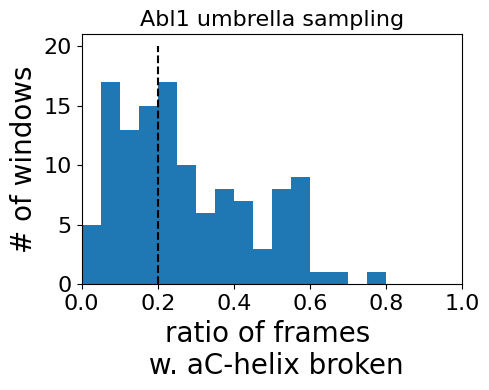

In [41]:
folder = '/content/drive/MyDrive/AF2RAVE-Glide/US_Abl1'

df = pd.read_csv(f'{folder}/ac.log', header=None,sep='\s+')
df.columns = ['win', 'ratio']
df.sort_values(by='ratio')

plt.figure(figsize=(5,4))

plt.hist(df['ratio'],bins=np.arange(0,1.05, 0.05))
plt.vlines(0.2, 0,20,'k', linestyles='dashed')


plt.tick_params(axis='both', labelsize=16)
plt.xticks([0,0.2,0.4,0.6,0.8,1])

plt.xlabel("ratio of frames \n w. aC-helix broken", fontsize=20)
plt.ylabel("# of windows", fontsize=20)
plt.xlim([0,1])
plt.title('Abl1 umbrella sampling', fontsize=16)
plt.tight_layout()
plt.savefig(f"{folder}/Abl1_ac_broken.png",dpi=300)

In [42]:
gwins = list(df[df['ratio']<0.2]['win'])
len(gwins)

50

<ipython-input-43-e09f2af31770>:22: RuntimeWarning: divide by zero encountered in log
  v1 = np.where(a>0, np.log(a), 0)
<ipython-input-43-e09f2af31770>:29: RuntimeWarning: divide by zero encountered in log
  v2 = np.where(a>0, np.log(a), 0)
<ipython-input-43-e09f2af31770>:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


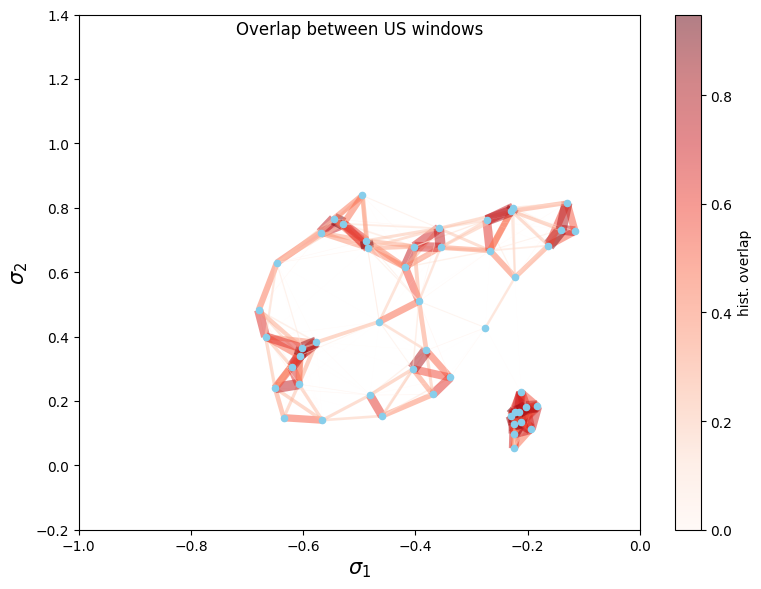

In [43]:
xbin = np.linspace(-1,0,51)
ybin = np.linspace(-0.1,1.5,81)

G = nx.Graph()
# node positions
pos = {}

for ii in range(len(gwins)):
    i = gwins[ii]
    cv_array = np.loadtxt(f'{folder}/cvs/{i}.txt')
    pos[ii] = (np.mean(cv_array.T[1]), np.mean(cv_array.T[2]))
G.add_nodes_from(pos.keys())

edge = []
edge_widths = []

for ii in range(len(gwins)):
    i = gwins[ii]
    cv_array1 = np.loadtxt(f'{folder}/cvs/{i}.txt')
    hist1, _, _ = np.histogram2d(cv_array1.T[1], cv_array1.T[2], bins = [xbin,ybin])
    a = np.concatenate(hist1)
    v1 = np.where(a>0, np.log(a), 0)
    for jj in range(ii+1,len(gwins)):
        j = gwins[jj]
        edge.append((ii,jj))
        cv_array2 = np.loadtxt(f'{folder}/cvs/{j}.txt')
        hist2, _, _ = np.histogram2d(cv_array2.T[1], cv_array2.T[2], bins = [xbin,ybin])
        a = np.concatenate(hist2)
        v2 = np.where(a>0, np.log(a), 0)
        edge_widths.append(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2))

for ed, width in zip(edge, edge_widths):
    G.add_edge(*ed, width=width)

# Draw the graph
fig, ax = plt.subplots(figsize=(8, 6))
# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue',ax=ax)

# Draw edges with specified widths
widths = [G[edge[0]][edge[1]]['width']*10 for edge in G.edges()]
cmap = cm.get_cmap('Reds')
g_edge = nx.draw_networkx_edges(G, pos, width=widths, edge_color=edge_widths, edge_cmap=cmap, alpha=0.5,ax=ax)

# Show the plot
#plt.title("Graph with Edge Widths")
plt.title('Overlap between US windows',y=1.0, pad=-14)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel("$\sigma_1$",fontsize=15)
plt.ylabel("$\sigma_2$",fontsize=15)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
plt.colorbar(g_edge, label='hist. overlap')
plt.tight_layout()
plt.savefig(f"figures/ABl1_lspace_us_G_wo_acBroken.png",dpi=300)

In [45]:
tmp_edge = []
for edge in G.edges():
    if G[edge[0]][edge[1]]['width'] > 0.1:
        tmp_edge.append(((edge[0],edge[1])))
G1 = nx.Graph()
G1.add_nodes_from(pos.keys())
for ed in tmp_edge:
    G1.add_edge(*ed)
groups = list(nx.connected_components(G1))
print(len(groups[0]))

eps = np.loadtxt(f'{folder}/eps.txt')

for ii in groups[0]:
    i = int(gwins[ii][1:])
    print(i, eps[i][0], eps[i][1])
# file_path = 'meta.txt'
# with open(file_path, 'w') as file:
#     for ii in groups[0]:
#         i = int(gwins[ii][1:])
#         file.write(f"/home/xgu/Tiwary/AF2RAVE/US_Abl1/cvs/w{i}.txt {eps[i][0]} {eps[i][1]} 1000 1000\n")

39
1 -0.73 0.0
4 -0.52 0.0
13 -0.66 0.08
16 -0.45 0.08
26 -0.52 0.16
33 -0.8 0.24
34 -0.73 0.24
40 -0.31 0.24
45 -0.73 0.32
47 -0.59 0.32
50 -0.38 0.32
51 -0.31 0.32
56 -0.73 0.4
62 -0.31 0.4
66 -0.8 0.48
67 -0.73 0.48
68 -0.66 0.48
70 -0.52 0.48
71 -0.45 0.48
78 -0.73 0.56
82 -0.45 0.56
83 -0.38 0.56
86 -0.17 0.56
88 -0.8 0.64
89 -0.73 0.64
90 -0.66 0.64
91 -0.59 0.64
92 -0.52 0.64
93 -0.45 0.64
95 -0.31 0.64
97 -0.17 0.64
98 -0.1 0.64
105 -0.38 0.72
107 -0.24 0.72
108 -0.17 0.72
115 -0.45 0.8
117 -0.31 0.8
118 -0.24 0.8
120 -0.1 0.8


**Assign Boltzmann rank**

In [46]:
mcs_ct = 0.7
temps = ['3OXZ','2HYY']
rank = pd.DataFrame()
pres = []
file_list = glob.glob('tAF2_Abl1/frames/*')
for file in file_list:
    pres.append(os.path.basename(file)[:-4])
rank['pres'] = pres
for ii, temp in enumerate(temps):
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'tAF2_Abl1/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        marks.append(np.min(sub[f'{temp}_l_RMSD']))
    rank[f'l_rmsd_{temp}'] = marks

tls_array = []
for file in file_list:
    traj = md.load(file)
    cv=kcv.kinase_cvs("Abl1",traj.top,resids_Abl1,traj)
    ops = []
    for j in op_id:
        ops.extend(cv.allcvs[j].traj)
    tls_array.append(np.dot(ops, wts.T))
tls_array=np.array(tls_array)
rank['sigma1']=tls_array.T[0]
rank['sigma2']=tls_array.T[1]
rank

,pres,l_rmsd_3OXZ,l_rmsd_2HYY,sigma1,sigma2
0,pred_1_ifdm,11.773567,12.734521,-0.514619,0.651168
1,pred_1_ifdd,13.639198,7.534497,-0.424599,0.768338
2,pred_2_ifdi,10.713761,12.799329,-0.468961,0.780458
3,pred_1_ifdi,11.658124,10.502872,-0.478994,0.841281
4,pred_2_ifdm,11.249187,11.928028,-0.517187,0.691050
5,pred_1_ifdc,7.908424,12.923129,-0.515279,0.677288
6,pred_1_ifdj,11.742258,6.586459,-0.450458,0.736166
7,pred_1_ifda,0.776245,7.355497,-0.495752,0.813720
8,pred_2_ifdf,2.815172,2.735841,-0.470218,0.836842
9,pred_1_ifdf,2.864420,3.731321,-0.468267,0.863100


In [47]:
folder

'/content/drive/MyDrive/AF2RAVE-Glide/US_Abl1'

In [48]:
a=pd.read_csv(f'{folder}/wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

a.columns = ['xx', 'yy', 'pmf','prob']
minp=np.min(a.pmf)
ct=0.05
pmfs = []
tls = tls_array
for tt in range(len(tls)):
    print(pres[tt], tls[tt])
    tx=tls[tt][0]
    ty=tls[tt][1]
    b=a[(a.xx>tx-ct) & (a.xx<tx+ct) & (a.yy>ty-ct) & (a.yy<ty+ct)]
    cand = []
    cand.append(list(b.xx))
    cand.append(list(b.yy))
    cand = np.transpose(cand)
    out_id = np.argmin(np.linalg.norm(tls[tt]-cand, axis=1))
    pmfs.append(np.round(b.iloc[out_id]['pmf'], decimals=3))
rank['pmf'] = pmfs

pred_1_ifdm [-0.51461857  0.6511677 ]
pred_1_ifdd [-0.42459928  0.76833819]
pred_2_ifdi [-0.46896052  0.78045838]
pred_1_ifdi [-0.47899361  0.84128142]
pred_2_ifdm [-0.51718734  0.6910502 ]
pred_1_ifdc [-0.51527925  0.67728774]
pred_1_ifdj [-0.45045776  0.73616644]
pred_1_ifda [-0.49575237  0.81371974]
pred_2_ifdf [-0.47021821  0.83684221]
pred_1_ifdf [-0.46826685  0.86309954]
pred_1_ifdb [-0.58858023  0.66398476]
pred_2_ifdg [-0.46847036  0.70425035]
pred_1_ifdo [-0.44902569  0.67827838]
pred_1_ifdk [-0.5233298   0.74469242]
pred_1_ifdg [-0.45976181  0.70601472]
pred_2_ifda [-0.49943501  0.78388892]
pred_1_ifdh [-0.51905097  0.65220169]
pred_2_ifdj [-0.50128328  0.72807317]
pred_2_ifdb [-0.51576485  0.66147678]
pred_2_ifdn [-0.49947274  0.77614808]
pred_1_ifdl [-0.56834764  0.75406154]
pred_2_ifdc [-0.52556758  0.67245643]
pred_1_ifde [-0.52929069  0.95428242]
pred_1_ifdn [-0.50193337  0.80019004]
pred_2_ifdo [-0.45131931  0.73175703]
pred_2_ifdk [-0.5151269   0.73782406]
pred_2_ifdh 

In [49]:
rank.sort_values(by=['pmf'],ignore_index=True)

,pres,l_rmsd_3OXZ,l_rmsd_2HYY,sigma1,sigma2,pmf
0,pred_1_ifdf,2.864420,3.731321,-0.468267,0.863100,4.426
1,pred_1_ifdn,10.485621,8.583688,-0.501933,0.800190,4.879
2,pred_1_ifdi,11.658124,10.502872,-0.478994,0.841281,5.062
3,pred_1_ifda,0.776245,7.355497,-0.495752,0.813720,5.397
4,pred_2_ifdf,2.815172,2.735841,-0.470218,0.836842,6.137
5,pred_2_ifda,0.895997,3.476961,-0.499435,0.783889,7.175
6,pred_2_ifdn,8.282616,8.150772,-0.499473,0.776148,8.285
7,pred_2_ifdi,10.713761,12.799329,-0.468961,0.780458,8.897
8,pred_2_ifdo,12.126323,7.395588,-0.451319,0.731757,11.569
9,pred_1_ifdj,11.742258,6.586459,-0.450458,0.736166,11.569


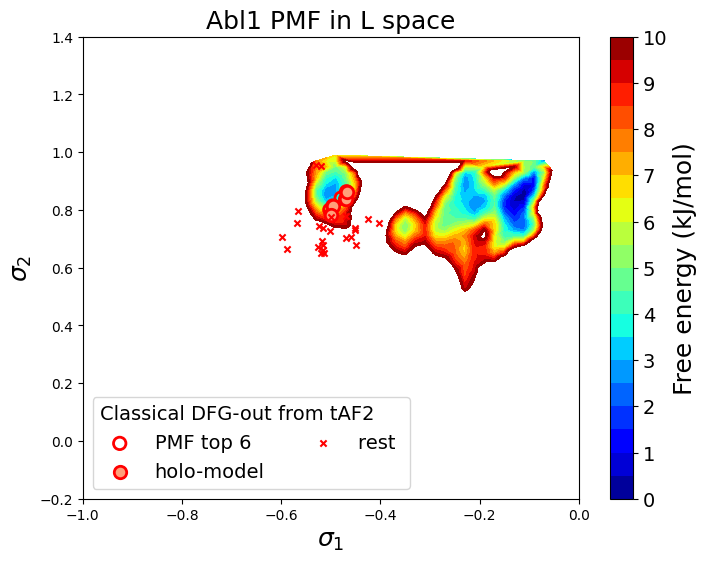

In [50]:
# pmf >8
cross = [rank[rank.pmf >8].sigma1.to_list(), rank[rank.pmf >8].sigma2.to_list()]
# pmf <8
circle = [rank[rank.pmf <8].sigma1.to_list(), rank[rank.pmf <8].sigma2.to_list()]
# winner
winner = [rank[rank.l_rmsd_3OXZ <3].sigma1.to_list(), rank[rank.l_rmsd_3OXZ <3].sigma2.to_list()]

plt.figure(figsize=(8, 6))
a=pd.read_csv(f'{folder}/wham_pmf.txt', header=None, delim_whitespace=True, comment='#')

a.columns = ['xx', 'yy', 'pmf','prob']
minp=np.min(a.pmf)
b=a[a.pmf<9999]
levels=np.arange(0, 10.5, 0.5)

ax = plt.gca()
minp=np.min(b.pmf)
CS = ax.tricontourf(b.xx, b.yy, b.pmf-minp, levels, cmap=plt.get_cmap('jet'))
plt.scatter(circle[0],circle[1], marker='o',linewidths=2,c='none',edgecolors='r',s=80,label='PMF top 6')
plt.scatter(winner[0],winner[1],marker='o',s=80, facecolors='lightsalmon', edgecolors='r',linewidths=2, label='holo-model')
plt.scatter(cross[0],cross[1],marker='x',linewidths=1.5,c='r',s=20,label='rest ')

plt.title('Abl1 PMF in L space',y=1.0,fontsize=18)
plt.xlabel("$\sigma_1$",fontsize=18)
plt.ylabel("$\sigma_2$",fontsize=18)
plt.xlim([-1,0])
plt.ylim([-0.2,1.4])
cbar = plt.colorbar(CS)
cbar.set_label(label='Free energy (kJ/mol)',size=18)

plt.legend(fontsize=14, loc='lower left', title='Classical DFG-out from tAF2',title_fontsize=14,alignment='left',ncol=2)
cbar.set_ticks(np.arange(0, 11, 1))
cbar.ax.tick_params(labelsize=14)
plt.savefig(f"Abl1_pmf.png",dpi=300)